In [206]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing

In [207]:
# Loading the MNIST datasets - 60000 images for training and 10000 images for testing
(imageTrain, labelTrain), (imageTest, labelTest) = tf.keras.datasets.mnist.load_data()

# Splitting the training set into 2: 55000 images for training and 5000 images for validation
imageTest = imageTest[:]
labelTest = labelTest[:]

imageValid = imageTrain[55000:]
labelValid = labelTrain[55000:]

imageTrain = imageTrain[:55000]
labelTrain = labelTrain[:55000]

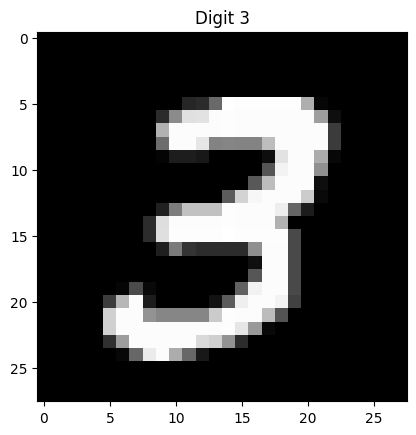

In [208]:
# Visualizing data
# Printing an array
def printArr(idx):
    to_write = ""
    for i in range(28):
        for j in range(28):
            if(len(str(imageTrain[idx][i][j])) == 1):
                to_write += str(imageTrain[idx][i][j]) + "    "
            elif(len(str(imageTrain[idx][i][j])) == 2):
                to_write += str(imageTrain[idx][i][j]) + "   "
            else:
                to_write += str(imageTrain[idx][i][j]) + "  "
        to_write += "\n"
    to_write += f"\nDigit: {labelTrain[idx]}"
    with open("./test/imageArr.txt", "w") as file:
        file.write(to_write)
        
# Plotting an image
def plotImage(idx):
    pyplot.title(f"Digit {labelTrain[idx]}")
    pyplot.imshow(imageTrain[idx], cmap='gray')
    pyplot.savefig("./test/digitGrey.jpg")

idx = 7
printArr(idx)
plotImage(idx)

In [209]:
# Preprocessing data (normalizing image arrays and 1-hot encoding label arrays)
# imageTest = np.reshape(imageTest, (10000, 784))
# imageTest = preprocessing.normalize(imageTest, norm = "max")
labelTest = tf.keras.utils.to_categorical(labelTest, num_classes=10)

# imageValid = np.reshape(imageValid, (5000, 784))
# imageValid = preprocessing.normalize(imageValid, norm = "max")
labelValid = tf.keras.utils.to_categorical(labelValid, num_classes=10)

# imageTrain = np.reshape(imageTrain, (55000, 784))
# imageTrain = preprocessing.normalize(imageTrain, norm="max")
labelTrain = tf.keras.utils.to_categorical(labelTrain, num_classes=10)

In [245]:
# Implementing a convolutional neural network with 1 convolution layer and 1 pooling layer
class CNN:
    def __init__(self, batchSize, iterations, learningRate):
        # Initializing model hyperparameters
        self.batchSize, self.iterations, self.learningRate = batchSize, iterations, learningRate
        self.stride = 1          # Stride for convolution layer
        self.padding = 0         # Padding for convolution layer
        self.kernelDim = 3       # Dimension of kernel = 3 x 3
        self.kernelNum = 5       # Number of kernels (filters)
        self.inputDim = 28       # Dimension of input images = 28 x 28
        self.featureDim = 26     # Dimension of feature map = inputDim + 2 * padding - kernelDim) / stride + 1 
        self.outputDim = 10      # Dimension of output results = 10 x 1
        self.sizeTest = 10000    # Size of test set
        self.sizeValid = 5000    # Size of validation set
        self.sizeTrain = 55000   # Size of training set
    
    # Convolution layer
    def convolutionFF(self, x, kernel):
        result = np.zeros((self.kernelNum, self.featureDim, self.featureDim))

        for n in range(self.kernelNum):
            for i in range(self.featureDim):
                for j in range(self.featureDim):
                    result[n, i, j] = np.sum(np.multiply(kernel[n], x[i : i + self.kernelDim, j : j + self.kernelDim]))
        return result
    
    def convolutionBP(self, x, kernel):
        result = np.zeros((1, self.kernelDim, self.kernelDim))
        for n in range(1):
            for i in range(self.kernelDim):
                for j in range(self.kernelDim):
                    result[n, i, j] = np.sum(np.multiply(kernel[n], x[i : i + self.featureDim, j : j + self.featureDim]))
        return result.reshape(3, 3)
    
    # Nonlinear layer using ReLU activation
    def relu(self, x):
        return x*(x > 0)
    
    def softmax(self, x):
        c = np.max(x, axis = 0, keepdims=True)
        x -= c
        e = np.exp(x)
        return e / np.sum(e, axis = 0, keepdims=True)
    
    def forwardfeed(self, x):
        v = self.convolutionFF(x, self.kernelList) # Feature map
        a = (self.relu(v)).reshape(self.kernelNum * self.featureDim ** 2, 1) # Feature map after ReLU
        z = np.dot(self.w, a) + self.b
        yCal = self.softmax(z)
        return (v, a, z, yCal)
    
    def backpropagation(self, x, yLabel, v, a, z, yCal):        
        e2 = (yCal - yLabel) / self.batchSize # gradient of softmax using cross entropy
        db = np.sum(e2, axis=1, keepdims=True)
        dw = np.dot(a, e2.T).T
        e1 = np.dot(self.w.T, e2)
        e1 = e1.reshape(5, 26, 26)
        e1[v <= 0] = 0
        dk = []
        for i in range(5):
            tmp_arr = np.multiply(v[i], e1[i])
            dk.append(self.convolutionBP(x, tmp_arr))
        
        return (db, dw, dk)
    
    def lossCE(self, yCal, yLabel):
        result = -np.sum(np.log(yCal) * yLabel) / self.batchSize
        return result
    
    def train(self, xTrain, yTrain):
        # Initializing random weights and biases for output layer
        self.w = 0.0001 * np.random.rand(self.outputDim, self.kernelNum * self.featureDim ** 2)
        self.b = 0.0001 * np.random.rand(self.outputDim, 1)
        # Initializing random kernels for convolution layer
        self.kernelList = []
        for n in range(self.kernelNum):
            kernel = 0.0001 * np.random.rand(self.kernelDim, self.kernelDim)
            self.kernelList.append(kernel)
        
        # Generating a random list of indices for mini BGD
        idxList = np.random.randint(low=0, high=self.sizeTrain, size=self.batchSize)

        count = 0
        for n in range(self.iterations):
            for idx in idxList:
                x = xTrain[idx]
                yLabel = yTrain[idx]
                v, a, z, yCal = self.forwardfeed(x)
                loss = self.lossCE(yCal, yLabel)
                db, dw, dk = self.backpropagation(x, yLabel.reshape(10, 1), v, a, z, yCal)
                
                #Updating weight, biases and kernels
                self.w += self.learningRate * dw
                self.b += self.learningRate * db
                for idx in range(self.kernelNum):
                    self.kernelList[idx] += self.learningRate * dk[idx]
                
            if n % 100 == 0:
                    print(f"[Iter {n}] Loss: {loss}\n")

        print("Training finished!")
    
    def test(self, xValid, yValid):
        correct = 0
        for n in range(100):
            x = xValid[n]
            yLabel = yValid[n]
            (v, a, z, yCal) = self.forwardfeed(x)
            prediction = np.argmax(yCal)
            answer = np.argmax(yLabel)
            print(prediction, answer)
            if (prediction == answer):
                correct += 1
                
        print(f"Accuarcy: {correct / 100}")
        
model = CNN(batchSize=1, iterations=1000, learningRate=0.01)



In [247]:
model.train(imageTrain, labelTrain)

[Iter 0] Loss: 23.025850952488113

[Iter 100] Loss: 27.584722265176133

[Iter 200] Loss: 33.302259177993704

[Iter 300] Loss: 39.0242597095683

[Iter 400] Loss: 44.746275706086934

[Iter 500] Loss: 50.46829440158156

[Iter 600] Loss: 56.19032139375504

[Iter 700] Loss: 61.912374343659

[Iter 800] Loss: 67.63450847860412

[Iter 900] Loss: 73.35689637040834

Training finished!


In [248]:
model.test(imageValid, labelValid)

2 1
2 2
2 8
2 7
2 4
2 4
2 0
2 9
2 3
2 9
2 5
2 2
2 6
2 9
2 1
2 8
2 6
2 3
2 6
2 6
2 8
2 7
2 8
2 0
2 4
2 4
2 8
2 0
2 3
2 0
2 0
2 1
2 2
2 2
2 7
2 3
2 1
2 4
2 3
2 6
2 2
2 7
2 5
2 8
2 2
2 0
2 1
2 1
2 0
2 2
2 3
2 3
2 7
2 4
2 3
2 5
2 0
2 6
2 5
2 7
2 5
2 8
2 3
2 9
2 9
2 0
2 6
2 1
2 9
2 2
2 2
2 3
2 9
2 4
2 4
2 5
2 5
2 6
2 7
2 7
2 1
2 8
2 7
2 1
2 7
2 4
2 7
2 4
2 7
2 2
2 7
2 3
2 9
2 3
2 7
2 0
2 6
2 9
2 4
2 5
Accuarcy: 0.1
